In [79]:
%load_ext autoreload
% autoreload 2
%matplotlib inline

import pprint
import os

import netCDF4
import numpy as np 
import pandas as pd
import sklearn

import matplotlib.pyplot as plt
import seaborn as sns

import solar_energy


sns.set_style('ticks')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [80]:
def todatetime(intdate):
    strdate = str(intdate)
    year = int(strdate[0:4])
    month = int(strdate[4:6])
    day = int(strdate[6:8])
    return pd.datetime(year, month, day)

In [81]:
ls ../data/train | wc -l

15


In [82]:
# load the simulation coords and elevations
def netcdf4_to_dataframe(netcdf):
    data_as_array = np.array([np.array(i).flatten() for i in netcdf.variables.values()]).T
    data_as_dataframe = pd.DataFrame(data_as_array, columns=netcdf.variables.keys())
    return data_as_dataframe

elevation = netCDF4.Dataset('../data/gefs_elevations.nc', 'r')
elevation_pd = netcdf4_to_dataframe(elevation)
elevation_pd['longitude'] = elevation_pd['longitude'] - 360.

In [83]:
# load the mesonet coords
station_info = pd.read_csv('../data/station_info.csv')
x = np.array(station_info['nlat']) - elevation_pd['latitude'].min()
y = np.array(station_info['elon']) - elevation_pd['longitude'].min()

In [84]:
training_y = pd.read_csv('../data/train.csv')
training_y.set_index('Date', inplace=True)
training_y.index = training_y.index.map(todatetime)

In [85]:
training_y.columns

Index(['ACME', 'ADAX', 'ALTU', 'APAC', 'ARNE', 'BEAV', 'BESS', 'BIXB', 'BLAC',
       'BOIS', 'BOWL', 'BREC', 'BRIS', 'BUFF', 'BURB', 'BURN', 'BUTL', 'BYAR',
       'CAMA', 'CENT', 'CHAN', 'CHER', 'CHEY', 'CHIC', 'CLAY', 'CLOU', 'COOK',
       'COPA', 'DURA', 'ELRE', 'ERIC', 'EUFA', 'FAIR', 'FORA', 'FREE', 'FTCB',
       'GOOD', 'GUTH', 'HASK', 'HINT', 'HOBA', 'HOLL', 'HOOK', 'HUGO', 'IDAB',
       'JAYX', 'KENT', 'KETC', 'LAHO', 'LANE', 'MADI', 'MANG', 'MARE', 'MAYR',
       'MCAL', 'MEDF', 'MEDI', 'MIAM', 'MINC', 'MTHE', 'NEWK', 'NINN', 'NOWA',
       'OILT', 'OKEM', 'OKMU', 'PAUL', 'PAWN', 'PERK', 'PRYO', 'PUTN', 'REDR',
       'RETR', 'RING', 'SALL', 'SEIL', 'SHAW', 'SKIA', 'SLAP', 'SPEN', 'STIG',
       'STIL', 'STUA', 'SULP', 'TAHL', 'TALI', 'TIPT', 'TISH', 'VINI', 'WASH',
       'WATO', 'WAUR', 'WEAT', 'WEST', 'WILB', 'WIST', 'WOOD', 'WYNO'],
      dtype='object')

In [86]:
training_y.index

DatetimeIndex(['1994-01-01', '1994-01-02', '1994-01-03', '1994-01-04',
               '1994-01-05', '1994-01-06', '1994-01-07', '1994-01-08',
               '1994-01-09', '1994-01-10',
               ...
               '2007-12-22', '2007-12-23', '2007-12-24', '2007-12-25',
               '2007-12-26', '2007-12-27', '2007-12-28', '2007-12-29',
               '2007-12-30', '2007-12-31'],
              dtype='datetime64[ns]', name='Date', length=5113, freq=None)

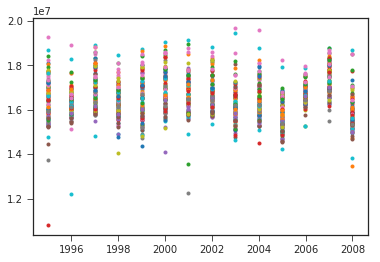

In [87]:
plt.plot(training_y.groupby(pd.Grouper(freq='Y')).mean(), '.');

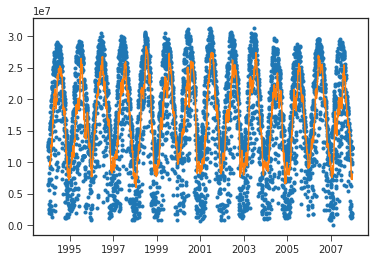

In [88]:
plt.plot(training_y['ACME'], '.')
plt.plot(training_y['ACME'].rolling(30).mean())

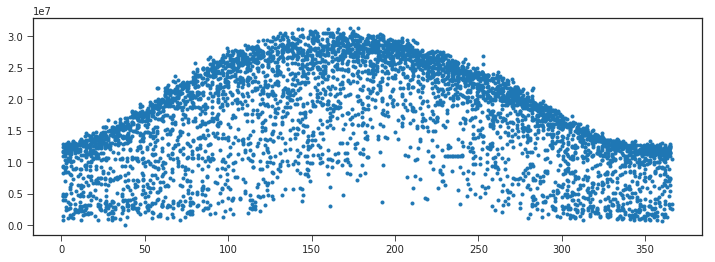

In [89]:
fig, ax = plt.subplots(figsize=(12, 4))
for sensor in training_y.columns[0:1]:
    ax.plot(training_y.index.dayofyear, training_y[sensor], '.')

In [90]:
apcp_ds = netCDF4.Dataset('../data/train/apcp_sfc_latlon_subset_19940101_20071231.nc', 'r')
apcp = np.array(list(apcp_ds.variables.values())[-1])

In [91]:


def interpolate_simulation_data(x, y, filename, location='../data/train/'):
    data_array = load_netcdf4_data(filename, location)
    interpolated_data = solar_energy.bilinear_interpolation(x, y, data_array)
    averaged_data = np.mean(interpolated_data, axis=1)  # average over ensembles
    averaged_data = np.mean(averaged_data, axis=1)  # average over forecast hours
    return averaged_data

def load_netcdf4_data(filename, location='../data/train/'):
    dataset = netCDF4.Dataset(location+filename, 'r')
    data_array = np.array(list(dataset.variables.values())[-1])
    return data_array
   

In [92]:
training_location = '../data/train/'
training_sim_filenames = os.listdir(training_location)
training_sim_names = ['_'.join(f.split('_')[0:2]) for f in training_sim_filenames]

training_sim_data = {n:interpolate_simulation_data(x, y, f, training_location) for n, f in 
                     zip(training_sim_names, training_sim_filenames)}

In [93]:
training_y[training_y.columns[0]]

Date
1994-01-01    12384900
1994-01-02    11908500
1994-01-03    12470700
1994-01-04    12725400
1994-01-05    10894800
1994-01-06     6639000
1994-01-07    13244700
1994-01-08    12927900
1994-01-09    12600300
1994-01-10     6406500
1994-01-11    12743400
1994-01-12    10453500
1994-01-13    12985200
1994-01-14    13080000
1994-01-15    11826300
1994-01-16     1974000
1994-01-17    13541700
1994-01-18    13673700
1994-01-19     6796800
1994-01-20     5658900
1994-01-21     7073400
1994-01-22     3354000
1994-01-23     2579700
1994-01-24     2387700
1994-01-25     8390700
1994-01-26     7326600
1994-01-27    10743900
1994-01-28    12812100
1994-01-29     9065100
1994-01-30     3954900
                ...   
2007-12-02    12177000
2007-12-03    13453800
2007-12-04    12525900
2007-12-05    10543500
2007-12-06     6214500
2007-12-07     8417400
2007-12-08     1683900
2007-12-09     1512300
2007-12-10     1729500
2007-12-11     1512600
2007-12-12     2126100
2007-12-13     3476400
2007-1

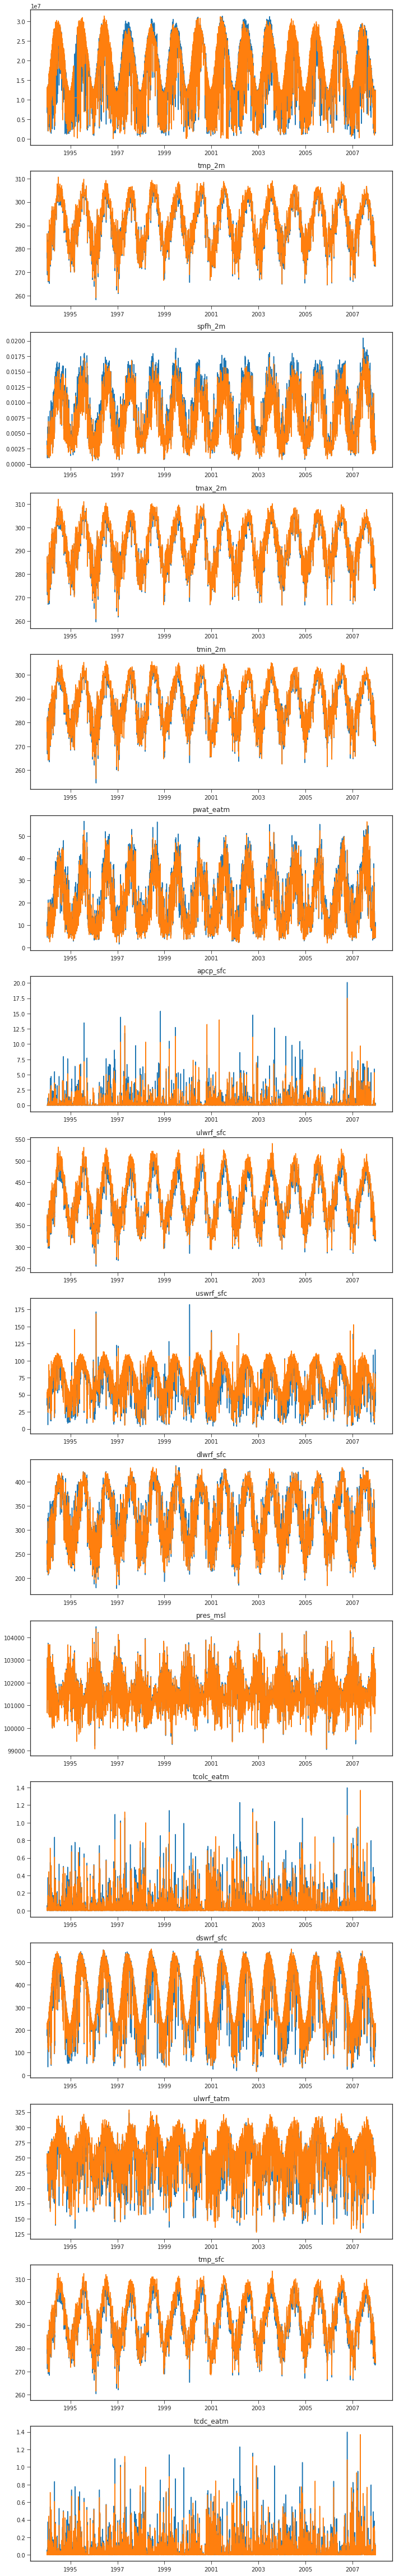

In [94]:
indices = [0, 2]
num_sims = len(training_sim_data)+1
fig, axes = plt.subplots(num_sims, 1, figsize=(10, 4*num_sims))
axes[0].plot(training_y.index, training_y[training_y.columns[indices]])
for (k, v), ax in zip(training_sim_data.items(), axes[1:].flatten()):
    ax.plot(training_y.index, v[:, indices])
    ax.set_title(k)
plt.tight_layout()

Looking at the correlations between the training data and the simulation data, there appear to be farily high correlations between the total sunlight incident on the solar arrays over the course of a day and the upward and downward shortwave radiative flux at the surface of the earth, averaged over models and forecast times.

## Load Testing Data

In [95]:
testing_location = '../data/test/'
testing_sim_filenames = os.listdir(testing_location)
testing_sim_names = ['_'.join(f.split('_')[0:2]) for f in testing_sim_filenames]

testing_sim_data = {n:interpolate_simulation_data(x, y, f, testing_location) for n, f in 
                     zip(testing_sim_names, testing_sim_filenames)}

In [96]:
sample_submission = pd.read_csv('../data/sampleSubmission.csv', index_col=0)

## Initial ML model

Ok, now I need to concatenate all my data so that I have a (5113, 98) array for the training data and a (5113, 98*2) array for the training input data, starting with just inputs 7 and 11 (upward and downward shortwave flux at surface).

I think I can drop the timestamps, as they don't really provide any predictive benefit. There could be some benefit to including the day of the year, perhaps, as a large part of the signal is cyclical. However, there is a little issue with leap years. Also, they training x data should already include the cyclical signal.

In [24]:
training_y = np.array(training_y)
training_x = np.hstack((training_sim_data['uswrf_sfc'], training_sim_data['dswrf_sfc']))
testing_x = np.hstack((testing_sim_data['uswrf_sfc'], testing_sim_data['dswrf_sfc']))

What are some techniques I could apply to this data? I am basically removing the time-dependence of the data and trying to model the correlations between the simulation data and real data.
- Linear regression
    - least squares
    - ridge regression
    - gaussian process
    - decision trees
    - neural network
- Non-linear regression
    - To do this, I think I will need to create the non-linear terms and add them to X, then a linear regression will include these higher-order terms.

In [25]:
from sklearn import linear_model
from sklearn.metrics import mean_absolute_error, explained_variance_score

### Ordinary least squares with only 2 input datasets

In [26]:
ols = linear_model.LinearRegression()
ols.fit(training_x, training_y)
print('ols score:',ols.score(training_x, training_y))
predicted_y = ols.predict(training_x)
print('mean absolute error:', mean_absolute_error(training_y, predicted_y))
print('explained variance score:', explained_variance_score(training_y, predicted_y))
test_predicted_y = ols.predict(testing_x)

ols score: 0.812343178614552
mean absolute error: 2484452.918344661
explained variance score: 0.8123291844334002


In [27]:
test_predicted_y = ols.predict(testing_x)
test_predictions_df = pd.DataFrame(test_predicted_y, 
                                   index=sample_submission.index, 
                                   columns=sample_submission.columns
                                  )
test_predictions_df.to_csv('../results/ols_2_shortwave.csv')

### OLS with all input datasets

In [28]:
training_x = np.hstack((v for v in training_sim_data.values()))
testing_x = np.hstack((v for v in testing_sim_data.values()))

In [29]:
model = linear_model.LinearRegression()

In [30]:
model.fit(training_x, training_y)
print('ols score:',model.score(training_x, training_y))
predicted_y = model.predict(training_x)
print('mean absolute error:', mean_absolute_error(training_y, predicted_y))
print('explained variance score:', explained_variance_score(training_y, predicted_y)) 

ols score: 0.7723890463129547
mean absolute error: 2798454.634727216
explained variance score: 0.8584944161511365


In [31]:
test_predicted_y = model.predict(testing_x)
test_predictions_df = pd.DataFrame(test_predicted_y, 
                                   index=sample_submission.index, 
                                   columns=sample_submission.columns
                                  )
test_predictions_df.to_csv('../results/ols_all_data.csv')

### Ridge regression with only 2 datasets

In [32]:
training_x = np.hstack((training_sim_data['uswrf_sfc'], training_sim_data['dswrf_sfc']))
testing_x = np.hstack((testing_sim_data['uswrf_sfc'], testing_sim_data['dswrf_sfc']))

In [33]:
from sklearn.linear_model import Ridge, RidgeCV

In [34]:
model = RidgeCV(alphas=(1.e-5, 1.e-3, 1.e-2, 1.e-1, 1.e0, 1.e2, 1.e3, 1.e5), store_cv_values=True)

In [35]:
model.fit(training_x, training_y)
print('model score:',model.score(training_x, training_y))
predicted_y = model.predict(training_x)
print('mean absolute error:', mean_absolute_error(training_y, predicted_y))
print('explained variance score:', explained_variance_score(training_y, predicted_y)) 

model score: 0.8121222678877477
mean absolute error: 2490319.4901177133
explained variance score: 0.8121076849274137


In [36]:
test_predicted_y = model.predict(testing_x)
test_predictions_df = pd.DataFrame(test_predicted_y, 
                                   index=sample_submission.index, 
                                   columns=sample_submission.columns
                                  )
test_predictions_df.to_csv('../results/ridge_shortwave.csv')

### Ridge regression with all datasets

In [37]:
training_x = np.hstack((v for v in training_sim_data.values()))
testing_x = np.hstack((v for v in testing_sim_data.values()))

In [38]:
model = Ridge(alpha=1.e3)

In [39]:
model.fit(training_x, training_y)
print('model score:',model.score(training_x, training_y))
predicted_y = model.predict(training_x)
print('mean absolute error:', mean_absolute_error(training_y, predicted_y))
print('explained variance score:', explained_variance_score(training_y, predicted_y)) 

model score: 0.8523420991813178
mean absolute error: 2158485.483624237
explained variance score: 0.8523314365989463


In [40]:
model = RidgeCV(alphas=(1.e-5, 1.e-3, 1.e-2, 1.e-1, 1.e0, 1.e2, 1.e3, 1.e5), store_cv_values=True)

In [41]:
model.fit(training_x, training_y)
print('model score:',model.score(training_x, training_y))
predicted_y = model.predict(training_x)
print('mean absolute error:', mean_absolute_error(training_y, predicted_y))
print('explained variance score:', explained_variance_score(training_y, predicted_y)) 

model score: 0.852342099181326
mean absolute error: 2158485.486677519
explained variance score: 0.8523314365989548


In [42]:
test_predicted_y = model.predict(testing_x)
test_predictions_df = pd.DataFrame(test_predicted_y, 
                                   index=sample_submission.index, 
                                   columns=sample_submission.columns
                                  )
test_predictions_df.to_csv('../results/ridge_all_data.csv')

### Lasso Regression with 2 datasets

In [43]:
from sklearn.linear_model import Lasso, LassoCV, LassoLarsCV, LassoLarsIC

In [44]:
from sklearn.linear_model import MultiTaskLasso, MultiTaskLassoCV

In [45]:
training_x = np.hstack((training_sim_data['uswrf_sfc'], training_sim_data['dswrf_sfc']))
testing_x = np.hstack((testing_sim_data['uswrf_sfc'], testing_sim_data['dswrf_sfc']))

In [46]:
#model = MultiTaskLasso(alpha=1.)

In [47]:
#model.fit(training_x, training_y)
#print('model score:',model.score(training_x, training_y))
#predicted_y = model.predict(training_x)
#print('mean absolute error:', mean_absolute_error(training_y, predicted_y))
#print('explained variance score:', explained_variance_score(training_y, predicted_y)) 

### Random Forest Regression with 2 datasets

In [51]:
from sklearn.ensemble import RandomForestRegressor

In [52]:
RandomForestRegressor?

In [53]:
training_x = np.hstack((training_sim_data['uswrf_sfc'], training_sim_data['dswrf_sfc']))
testing_x = np.hstack((testing_sim_data['uswrf_sfc'], testing_sim_data['dswrf_sfc']))

In [66]:
model = RandomForestRegressor(n_estimators=50)

In [67]:
model.fit(training_x, training_y)
print('model score:',model.score(training_x, training_y))
predicted_y = model.predict(training_x)
print('mean absolute error:', mean_absolute_error(training_y, predicted_y))
print('explained variance score:', explained_variance_score(training_y, predicted_y)) 

model score: 0.9723253046701945
mean absolute error: 909836.992457082
explained variance score: 0.972318060877907


In [68]:
test_predicted_y = model.predict(testing_x)
test_predictions_df = pd.DataFrame(test_predicted_y, 
                                   index=sample_submission.index, 
                                   columns=sample_submission.columns
                                  )
test_predictions_df.to_csv('../results/randomforest_shortwave_50_estimators.csv')

### Random Forest with all datasets

In [75]:
training_x = np.hstack((v for v in training_sim_data.values()))
testing_x = np.hstack((v for v in testing_sim_data.values()))

In [76]:
model = RandomForestRegressor(n_estimators=50)

In [77]:
model.fit(training_x, training_y)
print('model score:',model.score(training_x, training_y))
predicted_y = model.predict(training_x)
print('mean absolute error:', mean_absolute_error(training_y, predicted_y))
print('explained variance score:', explained_variance_score(training_y, predicted_y)) 

model score: 0.9738261018405089
mean absolute error: 878753.9396977692
explained variance score: 0.9738201091724766


In [78]:
test_predicted_y = model.predict(testing_x)
test_predictions_df = pd.DataFrame(test_predicted_y, 
                                   index=sample_submission.index, 
                                   columns=sample_submission.columns
                                  )
test_predictions_df.to_csv('../results/randomforest_all_data_estimators.csv')

### Gradient Boosting Regression

In [69]:
from sklearn.ensemble import GradientBoostingRegressor

In [73]:
model = GradientBoostingRegressor(loss='ls', n_estimators=100)

In [74]:
model.fit(training_x, training_y)
print('model score:',model.score(training_x, training_y))
predicted_y = model.predict(training_x)
print('mean absolute error:', mean_absolute_error(training_y, predicted_y))
print('explained variance score:', explained_variance_score(training_y, predicted_y)) 

ValueError: bad input shape (5113, 98)

What are some other improvements I could make to this model and my fitting of the model?
- break the training set into trainging/testing split or use cross validation in the fitting
- try some other 'cumulation' method for reducing the feature size over simulation ensemble and forecasts
    - in particular, I think I could try summing over the forecast times, or integrating over a linear/spline interpolation of the forecast times and then performing an average or weighted average over simulation ensembles.
- I am currently not incorporating simulation or mesonet elevation into the model. I could do so in a crude way by weighting the different simulation ensembles by their simulated elevations. 
    - There are 2 different elevations for the ensembles---the control simulation is at one elevation and all the other ensembles are at a second elevation.
    - I should check to to see if the mesonet elevations all lie between the two sets of simulation elevations.
        - However, the simulation elevations are not at the same lat/lon of the mesonets, so I will first need to interpolate the simulation elevations onto the mesonet points. I can do this using the same interpolation scheme as for the other simulation data.
    - If the mesonet elevations do all lie between the two sets of interpolated simulation elevations, then I can weight the ensembles by their closeness to the mesonet elevation when averaging over the elevations.
- Perform a more rigorous feature reduction of the 15 properties with a given model. I could use PCA or similar to see which combinations of the parameters contributes the most to the variance.
- I could include previous time-step data as features in the model. This would only work for the simulation data, as I would need to be able to construct this feature for the testing data. 
    - The amount of time shift, number of time-shifted entries, and which properties to use in creating time-shifted entries are all variables I can play with here.